In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/victor/catkin_ws_AI4HRI/src/ai4hri/simulated data.csv")

costumer = df.iloc[:,14]
costumer_clean = costumer.dropna()

shopkeeper = df.iloc[:,16]
shopkeeper_clean = shopkeeper.dropna()

costumer_list = costumer_clean.values.tolist()
shopkeeper_list = shopkeeper_clean.values.tolist()

print(shopkeeper_clean)
print(len(shopkeeper_list))

1                       good afternoon how can I help today
2         Yes we do have this nikon camera it's a point ...
3         This camera is very easy to use. Just choose a...
4         Because it's fully automatic sometimes gets a ...
5                thanks for your time have a good afternoon
                                ...                        
124170             can I ask what sort of pictures you take
124171    let me explain the layout of the store, the ni...
124172    it also has 18 different modes where you can t...
124173    this camera comes in purple pink black silver ...
124174                                      Thanks for time
Name: SHOPKEEPER_SPEECH, Length: 95430, dtype: object
95430


In [2]:
import openai
import os

openai.organization = os.environ['OPENAI_ORG_ID']
openai.api_key = os.environ["OPENAI_API_KEY"]

model = "text-embedding-ada-002"

res = openai.Embedding.create( input = shopkeeper_list[:100], engine=model)

In [3]:
import numpy

list=[]
for vec in res["data"]:
    list.append(vec["embedding"])

arr = numpy.asarray(list)
print(arr.shape)


(100, 1536)


/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (92) found smaller than n_clusters (93). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (92) found smaller than n_clusters (94). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (92) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (92) found smaller than n_clusters (96). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/

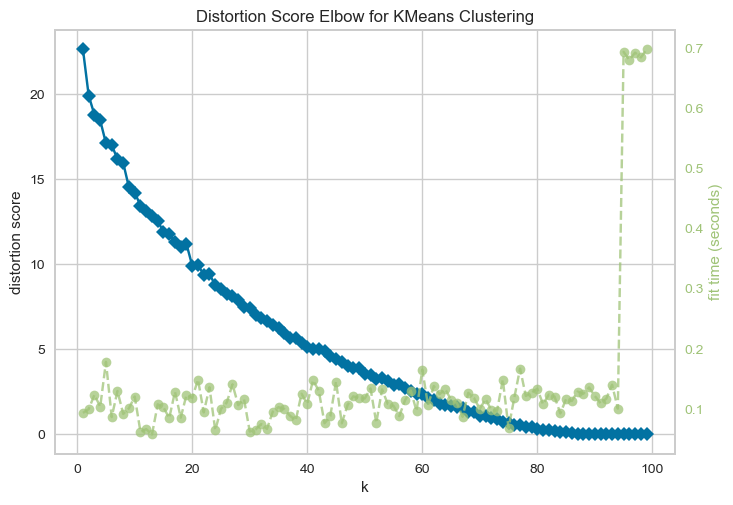

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init="auto")
visualizer = KElbowVisualizer(model, k=(1,100), locate_elbow=False)

visualizer.fit(arr)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [21]:
n_clusters = 45
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(arr)
np.save("kmeans_model.npy", kmeans)
y = kmeans.predict(arr)

print(y)

[11 19 29 22 23 44 19  4 21 27 16 17  8  5 26 30 12 24 31 35  0 18  5 31
 37 31 25 34  0 13 14 15 19 32 10 12 24 34  5  7 29 20 18 31  6  9 15 20
 20 42 11 40 43  7  2 11 29 22 16 11  3 15  3 37 17  3 28 27  9 23 11  1
  6  5  7 33  6 39  7  4  6 29 29 30  6 36 31 18  5 28  0 41 15  5 38  2
 11 12 19  4]


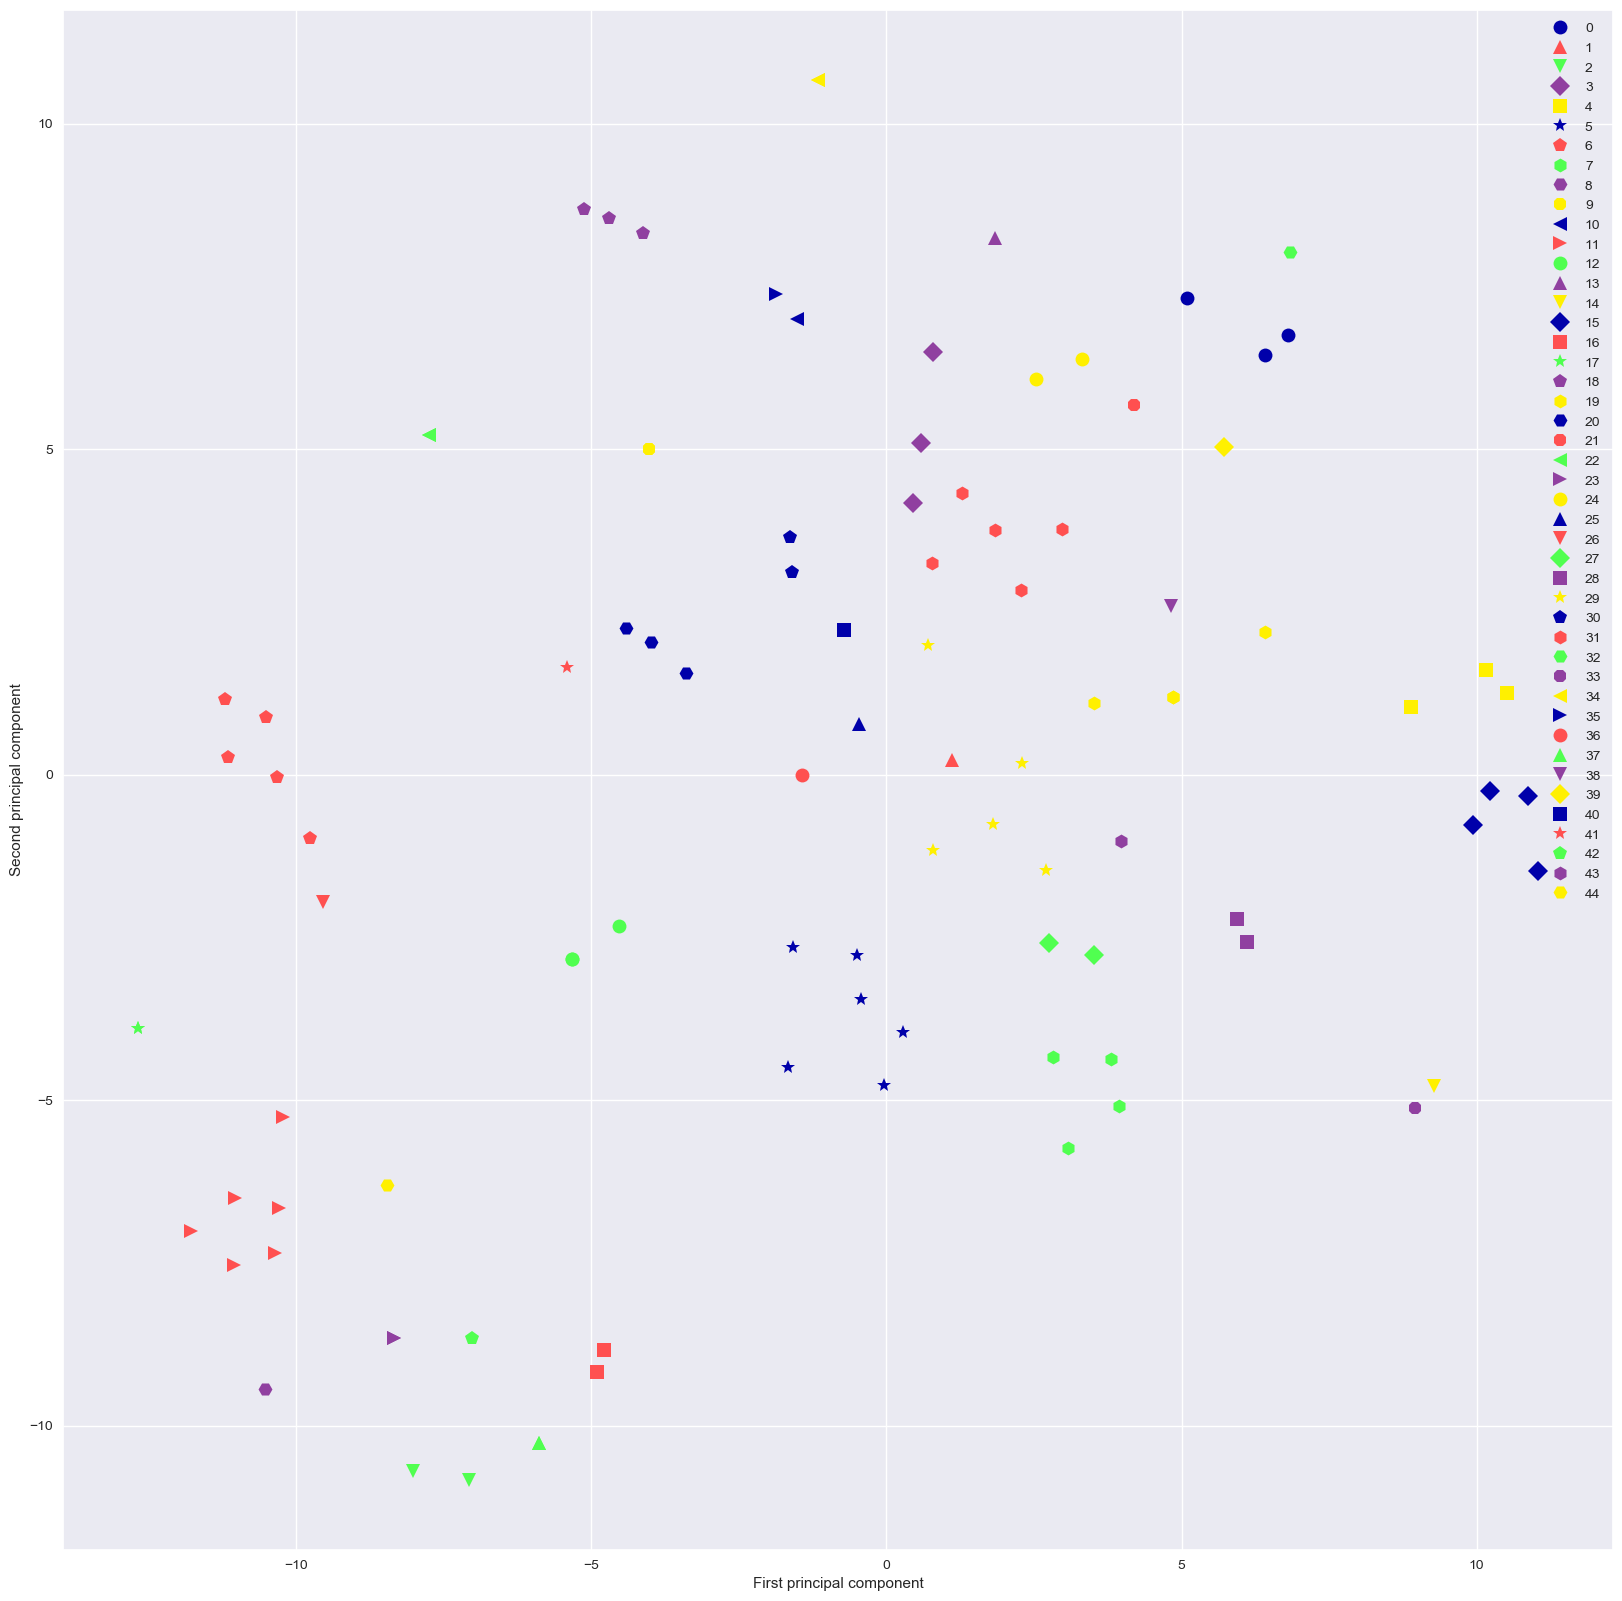

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plot_scatter as ps

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(arr)

n_classes=np.arange(0, 50, 1).tolist()
s = []
for x in n_classes:
    s.append(str(x))

plt.figure(figsize=(20, 20))
sns.set_style('darkgrid')
ps.discrete_scatter(tsne_result[:, 0], tsne_result[:, 1], y)
plt.legend(s, loc="best")
#plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()





In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

cluster_X = np.where(y == 17)[0]

vector_list = []
for j in cluster_X:
    print(shopkeeper_list[j])
    print(arr[j])
    vector_list.append(arr[j].tolist())
    print("----------------------")

print("Cosine similarity between a given utterance and the rest of the cluster:")
cluster_sum_list = []
for i in range(len(vector_list)):
    total_sum=0
    for j in range(len(vector_list)):
        total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
    cluster_sum_list.append(total_sum)
    print(cluster_sum_list[i])

print("----------------------")
cluster_sum_array = numpy.array(cluster_sum_list)
typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
print("Typical utterance inside the cluster: " + typical_utt)

kw_model = KeyBERT(model='all-mpnet-base-v2')
keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)

print("Assigned keywords to the utterance: " + str(keywords))





do you need anything
[ 0.00055249  0.01613884  0.00468689 ... -0.01341524  0.01157698
 -0.00643391]
----------------------
do you need anything
[ 0.00055249  0.01613884  0.00468689 ... -0.01341524  0.01157698
 -0.00643391]
----------------------
Cosine similarity between a given utterance and the rest of the cluster:
[[2.]]
[[2.]]
----------------------
Typical utterance inside the cluster: do you need anything
Assigned keywords to the utterance: [('need', 0.4446)]


In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

keyword_dict = {}
for z in range(n_clusters):
    cluster_X = np.where(y == z)[0]
    vector_list = []
    for j in cluster_X:
        vector_list.append(arr[j].tolist())

    cluster_sum_list = []
    for i in range(len(vector_list)):
        total_sum=0
        for j in range(len(vector_list)):
            total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
        cluster_sum_list.append(total_sum)

    cluster_sum_array = numpy.array(cluster_sum_list)
    typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
    print("Cluster " + str(z) + ": " + typical_utt)

    kw_model = KeyBERT(model='all-mpnet-base-v2')
    keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)
    print("Keywords: " + str(keywords))
    print("---------------")

    keyword_dict[z] = keywords

np.save("keyword_dict.npy", keyword_dict)

Cluster 0: It have full manual control
Keywords: [('manual', 0.4916), ('control', 0.4099)]
---------------
Cluster 1: this is the best one for good sociable pictures family and friends, it's designed for that to be point and shoot for the fast response
Keywords: [('friends', 0.3458), ('sociable', 0.3277), ('family', 0.2866), ('pictures', 0.236), ('best', 0.1481), ('response', 0.1277), ('shoot', 0.1215), ('point', 0.1072), ('fast', 0.0941), ('designed', 0.0243)]
---------------
Cluster 2: good thanks yourself
Keywords: [('thanks', 0.4145), ('good', 0.4128)]
---------------
Cluster 3: This is the Sony, it has 179 autofocus points which will help you get great sports photos
Keywords: [('autofocus', 0.467), ('sony', 0.4123), ('sports', 0.3305), ('photos', 0.2261), ('points', 0.2114), ('179', 0.1577), ('help', 0.0324), ('great', -0.0487)]
---------------
Cluster 4: yes it comes in 4 other different colors purple pink black and red
Keywords: [('pink', 0.3343), ('purple', 0.3076), ('red', 0.3

In [25]:
openai.organization = os.environ.get("OPENAI_ORG_ID")
openai.api_key = os.environ.get("OPENAI_API_KEY")

model = "text-embedding-ada-002"

res2 = openai.Embedding.create( input = ["this camera is available in black, white and silver"], engine=model)

list2=[]
for vec in res2["data"]:
    list2.append(vec["embedding"])

arr2 = numpy.asarray(list2)

y = kmeans.predict(arr2)
print("Cluster:" + str(y[0]))
print("Keywords:" + str(keyword_dict[y[0]]))

Cluster:15
Keywords:[('silver', 0.4333), ('black', 0.3786), ('colors', 0.363), ('white', 0.331), ('comes', 0.1953), ('different', 0.1356)]


In [104]:
# PENDIENTE:
# Juntar Whisper con embedder (Ejecutar Whisper en ROS_node, publicar utterances. Ejecutar Ada_Embedder en otro ROS_node suscrito al topic anterior)
# Hacer cluster de todo el dataset de Malcolm. Disminuir dimensiones vectores embebbed? 
# Crear tabla SQL para guardar embbeddings, typical utterances, keywords?
# Crear tabla SQL con fichas características camaras, implementar en python. Juntar keywords de las dos ultimas utterances. Comparar keywords con indices tablas camaras. 
# Comprobar si las keywords del shopkeeper que describen el producto corresponden con el contenido de las tablas. En caso afirmativo, conoce esa característica en concreto.
# 